### An example implementation of the AffectEval pipeline using the WESAD dataset

In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join("../affecteval"))
sys.path.insert(0, module_path)
module_path = os.path.abspath(os.path.join(".."))
sys.path.insert(0, module_path)

import numpy as np
import pandas as pd
import wesad

from affecteval import signals
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

subject_indices = list(range(2, 12)) + list(range(13, 18))
SUBJECTS = [str(i) for i in subject_indices]

# NOTE: Change ROOT_DIR according to your own file structure. This will be the only place you will need to do this.
# ROOT_DIR = "/Users/emilyzhou/Desktop/Research/AffectEval/"
ROOT_DIR = "C:\\Users\\zhoux\\Desktop\\Projects\\AffectEval"
DATA_DIR = os.path.join(ROOT_DIR, "data")
WESAD_PATH = os.path.join(DATA_DIR, "WESAD")
SOURCE_FOLDER = os.path.join(WESAD_PATH, "formatted")
ANNOTATIONS_PATH = os.path.join(WESAD_PATH, "annotations")
METRICS = os.path.join(DATA_DIR, "metrics", "WESAD")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Format data to be compatible with AffectEval pipeline
# Only needs to be run once locally 

import glob
import os


# wesad.reformat_and_save_data(WESAD_PATH)

# Rename Medi_1 and Medi_2 files to Medi1 and Medi2
files_to_rename = glob.glob(os.path.join(SOURCE_FOLDER, "*/*Medi_*.csv"))
for file in files_to_rename:
    file_name = file.split("_")
    new_name = f"{file_name[0]}_{file_name[1]}{file_name[2]}_{file_name[3]}"
    os.rename(file, new_name)

In [6]:
labels = wesad.generate_labels(ANNOTATIONS_PATH, threshold="dynamic")
# print(labels)

def generate_labels(data):
    """
    Generate binary labels for WESAD based on the STAI questionnaire and the input data format.
    
    Parameters
    --------------------
    :param data: Features to generate labels for. Must include subject ID and phase columns.
    :type data: pd.DataFrame

    Returns
    --------------------
    Generated labels and the unmodified input data.
    """
    annotations = wesad.generate_labels(ANNOTATIONS_PATH, threshold="dynamic")
    labels = []
    for i in range(data.shape[0]):
        subject = int(data["subject"].iloc[i])
        phase = data["Phase"].iloc[i]
        label_row = annotations.loc[(annotations["subject"] == subject)]
        label = label_row[phase]
        labels.append(label)
    labels = np.array(labels).ravel()
    return labels, data

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\zhoux\\Desktop\\Projects\\AffectEval\\data\\WESAD\\annotations\\S2_quest.csv'

### Binary stress classification

In [ ]:
# Build pipeline with default preprocessing and feature extraction methods

from affecteval.signal_acquisition.signal_acquisition import SignalAcquisition
from affecteval.signal_preprocessor.signal_preprocessor import SignalPreprocessor
from affecteval.feature_extractor.feature_extractor import FeatureExtractor
from affecteval.label_generator.label_generator import LabelGenerator
from affecteval.feature_selector.feature_selector import FeatureSelector
from affecteval.classification.estimator import Estimator
from affecteval.pipeline.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# import xgboost as xgb
# from xgb import XG


signal_types = [
    signals.Signals.ECG,
    signals.Signals.EDA
]
feature_names = [
    signals.Features.HR, signals.Features.RMSSD, signals.Features.SDNN,
    # signals.Features.HR,
    signals.Features.MEAN_SCL, signals.Features.SCR_RATE
]

label_gen = generate_labels
signal_acq = SignalAcquisition(signal_types=signal_types, source_folder=SOURCE_FOLDER)
signal_preprocessor = SignalPreprocessor(skip=True, resample_rate=250)
feature_extractor = FeatureExtractor(calculate_mean=True)
label_generator = LabelGenerator(label_generation_method=label_gen)

model = SVC()
# model = KNeighborsClassifier()
estimator_train = Estimator(0, model, name="SVC training")
estimator_test = Estimator(1, model, name="SVC testing")
estimator_train_val_test = Estimator(2, model, name="SVC train-val-test")

pipeline = Pipeline()

pipeline.generate_nodes_from_layers(
    # [signal_acq, signal_preprocessor, feature_extractor]
    # [signal_acq, signal_preprocessor, feature_extractor, label_generator, feature_selector]
    # [signal_acq, signal_preprocessor, feature_extractor, label_generator, feature_selector, estimator_train, estimator_test]
    [signal_acq, signal_preprocessor, feature_extractor, label_generator, estimator_train_val_test]
)

accs = []
aucs = []

for i in range(5):
    # We leave it up to the user to handle the final output of the pipeline. 
    out = pipeline.run()

    # Results
    # fitted_model = out[0]
    y_true = out[1]
    y_pred = out[2]

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    # f1 = f1_score(y_true, y_pred)

    accs.append(acc)
    aucs.append(auc)

print(f"\nMean accuracy: {np.mean(accs)}")
print(f"STD accuracy: {np.std(accs)}")
print(f"Mean AUC score: {np.mean(aucs)}")
print(f"STD AUC score: {np.std(aucs)}")

Running node Signal Acquisition...
- Elapsed time: 0.0 s
Running node Signal Preprocessor...
- Elapsed time: 0.38 s
Running node Feature Extractor...


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


- Elapsed time: 15.949 s
Running node Label Generator...
['mean_SCL', 'SCR_rate', 'HR', 'RMSSD', 'SDNN']
- Elapsed time: 0.054 s
Running node SVC train-val-test...
Cross-validation scores: [0.58333333 0.58333333 0.58333333 0.66666667 0.66666667]
- Elapsed time: 0.01 s
Running node Signal Acquisition...
- Elapsed time: 0.0 s
Running node Signal Preprocessor...
- Elapsed time: 0.358 s
Running node Feature Extractor...


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


- Elapsed time: 16.031 s
Running node Label Generator...
['mean_SCL', 'SCR_rate', 'HR', 'RMSSD', 'SDNN']
- Elapsed time: 0.06 s
Running node SVC train-val-test...
Cross-validation scores: [0.66666667 0.625      0.625      0.625      0.625     ]
- Elapsed time: 0.012 s
Running node Signal Acquisition...
- Elapsed time: 0.0 s
Running node Signal Preprocessor...
- Elapsed time: 0.355 s
Running node Feature Extractor...


100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


- Elapsed time: 15.634 s
Running node Label Generator...
['mean_SCL', 'SCR_rate', 'HR', 'RMSSD', 'SDNN']
- Elapsed time: 0.067 s
Running node SVC train-val-test...
Cross-validation scores: [0.63888889 0.63888889 0.63888889 0.66666667 0.66666667]
- Elapsed time: 0.013 s
Running node Signal Acquisition...
- Elapsed time: 0.0 s
Running node Signal Preprocessor...
- Elapsed time: 0.356 s
Running node Feature Extractor...


100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


- Elapsed time: 15.656 s
Running node Label Generator...
['mean_SCL', 'SCR_rate', 'HR', 'RMSSD', 'SDNN']
- Elapsed time: 0.075 s
Running node SVC train-val-test...
Cross-validation scores: [0.64583333 0.64583333 0.625      0.625      0.625     ]
- Elapsed time: 0.017 s
Running node Signal Acquisition...
- Elapsed time: 0.0 s
Running node Signal Preprocessor...
- Elapsed time: 0.354 s
Running node Feature Extractor...


100%|██████████| 15/15 [00:15<00:00,  1.04s/it]

- Elapsed time: 15.676 s
Running node Label Generator...
['mean_SCL', 'SCR_rate', 'HR', 'RMSSD', 'SDNN']
- Elapsed time: 0.082 s
Running node SVC train-val-test...
Cross-validation scores: [0.6        0.6        0.6        0.61666667 0.61666667]
- Elapsed time: 0.02 s

Mean accuracy: 0.688
STD accuracy: 0.05998518335574396
Mean AUC score: 0.5
STD AUC score: 0.0


### Subject identification

In [ ]:
# Build pipeline with default preprocessing and feature extraction methods

from affecteval.signal_acquisition.signal_acquisition import SignalAcquisition
from affecteval.signal_preprocessor.signal_preprocessor import SignalPreprocessor
from affecteval.feature_extractor.feature_extractor import FeatureExtractor
from affecteval.label_generator.label_generator import LabelGenerator
from affecteval.feature_selector.feature_selector import FeatureSelector
from affecteval.classification.estimator import Estimator
from affecteval.pipeline.pipeline import Pipeline

from sklearn.svm import SVC


signal_types = [
    signals.Signals.ECG,
    signals.Signals.EDA
]
feature_names = [
    signals.Features.HR, signals.Features.RMSSD, signals.Features.SDNN,
    # signals.Features.HR,
    signals.Features.MEAN_SCL, signals.Features.SCR_RATE
]

labels = os.path.join(WESAD_PATH, "ANNOTATIONS_PATH")
label_gen = "subject"
signal_acq = SignalAcquisition(signal_types=signal_types, source_folder=SOURCE_FOLDER)
signal_preprocessor = SignalPreprocessor(skip=True, resample_rate=0)
feature_extractor = FeatureExtractor()
label_generator = LabelGenerator(label_generation_method=label_gen)

model = SVC()
feature_selector = FeatureSelector(model, feature_names, num_features=3)
estimator_train = Estimator(0, model, name="SVC training")
estimator_test = Estimator(1, model, name="SVC testing")
estimator_train_val_test = Estimator(2, model, name="SVC train-val-test")

pipeline = Pipeline()

pipeline.generate_nodes_from_layers(
    # [signal_acq, signal_preprocessor, feature_extractor]
    # [signal_acq, signal_preprocessor, feature_extractor, label_generator, feature_selector]
    # [signal_acq, signal_preprocessor, feature_extractor, label_generator, feature_selector, estimator_train, estimator_test]
    [signal_acq, signal_preprocessor, feature_extractor, label_generator, feature_selector, estimator_train_val_test]
)

# We leave it up to the user to handle the final output of the pipeline. 
out = pipeline.run()

# Results
# fitted_model = out[0]
y_true = out[1]
y_pred = out[2]

acc = accuracy_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred)

print(f"\nAccuracy: {acc}")
# print(f"F1-score: {f1}")

Running node Signal Acquisition...
- Elapsed time: 0.0 s
Running node Signal Preprocessor...
- Elapsed time: 0.376 s
Running node Feature Extractor...


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


- Elapsed time: 16.208 s
Running node Label Generator...
- Elapsed time: 0.0 s
Running node Feature Selector...
- Elapsed time: 0.209 s
Running node SVC train-val-test...
Cross-validation scores: [0.25       0.25       0.08333333 0.25       0.16666667]
- Elapsed time: 0.015 s

Accuracy: 0.06666666666666667


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Phase identification

In [ ]:
# Build pipeline with default preprocessing and feature extraction methods

from affecteval.signal_acquisition.signal_acquisition import SignalAcquisition
from affecteval.signal_preprocessor.signal_preprocessor import SignalPreprocessor
from affecteval.feature_extractor.feature_extractor import FeatureExtractor
from affecteval.label_generator.label_generator import LabelGenerator
from affecteval.feature_selector.feature_selector import FeatureSelector
from affecteval.classification.estimator import Estimator
from affecteval.pipeline.pipeline import Pipeline

from sklearn.svm import SVC


signal_types = [
    signals.Signals.ECG,
    signals.Signals.EDA
]
feature_names = [
    signals.Features.HR, signals.Features.RMSSD, signals.Features.SDNN,
    # signals.Features.HR,
    signals.Features.MEAN_SCL, signals.Features.SCR_RATE
]

labels = os.path.join(WESAD_PATH, "ANNOTATIONS_PATH")
label_gen = "phase"
signal_acq = SignalAcquisition(signal_types=signal_types, source_folder=SOURCE_FOLDER)
signal_preprocessor = SignalPreprocessor(skip=True, resample_rate=0)
feature_extractor = FeatureExtractor()
label_generator = LabelGenerator(label_generation_method=label_gen)

model = SVC()
feature_selector = FeatureSelector(model, feature_names, num_features=3)
estimator_train = Estimator(0, model, name="SVC training")
estimator_test = Estimator(1, model, name="SVC testing")
estimator_train_val_test = Estimator(2, model, name="SVC train-val-test")

pipeline = Pipeline()

pipeline.generate_nodes_from_layers(
    # [signal_acq, signal_preprocessor, feature_extractor]
    # [signal_acq, signal_preprocessor, feature_extractor, label_generator, feature_selector]
    # [signal_acq, signal_preprocessor, feature_extractor, label_generator, feature_selector, estimator_train, estimator_test]
    [signal_acq, signal_preprocessor, feature_extractor, label_generator, feature_selector, estimator_train_val_test]
)

# We leave it up to the user to handle the final output of the pipeline. 
out = pipeline.run()

# Results
# fitted_model = out[0]
y_true = out[1]
y_pred = out[2]

acc = accuracy_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred)

print(f"\nAccuracy: {acc}")
# print(f"F1-score: {f1}")

Running node Signal Acquisition...
- Elapsed time: 0.0 s
Running node Signal Preprocessor...
- Elapsed time: 0.375 s
Running node Feature Extractor...


100%|██████████| 15/15 [00:15<00:00,  1.07s/it]

- Elapsed time: 15.993 s
Running node Label Generator...
- Elapsed time: 0.0 s
Running node Feature Selector...
- Elapsed time: 0.093 s
Running node SVC train-val-test...
Cross-validation scores: [0.16666667 0.16666667 0.16666667 0.25       0.16666667]
- Elapsed time: 0.011 s

Accuracy: 0.06666666666666667


Running node Signal Acquisition...
- Elapsed time: 0.0 s
Running node Signal Preprocessor...
- Elapsed time: 0.258 s


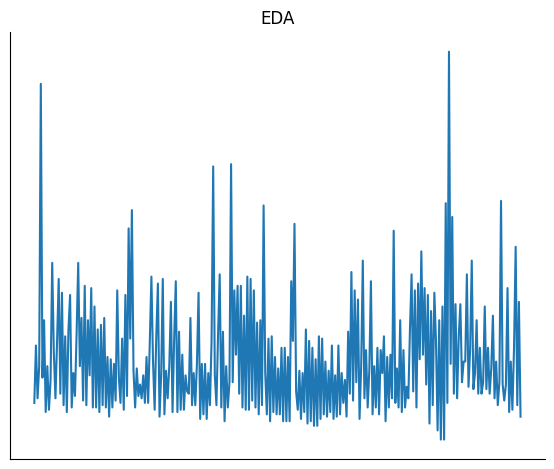

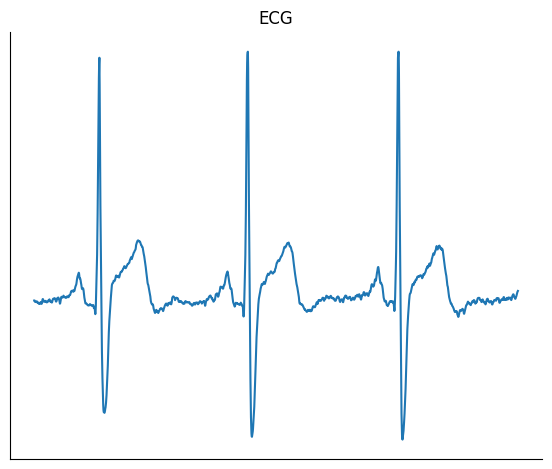

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


signal_types = [
    signals.Signals.ECG,
    signals.Signals.EDA
]
feature_names = [
    signals.Features.HR, signals.Features.RMSSD, signals.Features.SDNN,
    # signals.Features.HR,
    signals.Features.MEAN_SCL, signals.Features.SCR_RATE
]

label_gen = generate_labels
signal_acq = SignalAcquisition(signal_types=signal_types, source_folder=SOURCE_FOLDER)
signal_preprocessor = SignalPreprocessor(skip=True, resample_rate=250)
feature_extractor = FeatureExtractor()
label_generator = LabelGenerator(label_generation_method=label_gen)

model = SVC()
model = KNeighborsClassifier()
feature_selector = FeatureSelector(model, feature_names, num_features=3)
estimator_train = Estimator(0, model, name="SVC training")
estimator_test = Estimator(1, model, name="SVC testing")
estimator_train_val_test = Estimator(2, model, name="SVC train-val-test")

pipeline = Pipeline()

pipeline.generate_nodes_from_layers(
    [signal_acq, signal_preprocessor]
)

out = pipeline.run()

data = out[0]['9']
eda = data[0][300:600]
ecg = data[1][300:2200]

eda = sns.relplot(x='timestamp', y='EDA', kind='line', aspect=1.25, data=eda)
eda.set(xticks=[])
eda.set(yticks=[])
eda.set_xlabels("")
eda.set_ylabels("")
eda.set(title="EDA")
plt.show()

ecg = sns.relplot(x='timestamp', y='ECG', kind='line', aspect=1.25, data=ecg)
ecg.set(xticks=[])
ecg.set(yticks=[])
ecg.set_xlabels("")
ecg.set_ylabels("")
ecg.set(title="ECG")
plt.show()